In [14]:
import torch
import torch.nn as nn

from models import scribbler, discriminator, texturegan, localDiscriminator
import torch.optim as optim
from torch.autograd import Variable

import sys, os
from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import visdom
from IPython.display import display
import torchvision.models as models
from dataloader import imfol
from torch.utils.data.sampler import SequentialSampler

from torch.utils.data import DataLoader
from dataloader.imfol import ImageFolder, make_dataset

from utils import transforms as custom_transforms
from utils.visualize import vis_patch, vis_image
from models import scribbler, discriminator, define_G, weights_init, scribbler_dilate_128
import argparser

In [15]:
import argparse

def parse_arguments(argv):
    parser = argparse.ArgumentParser()

    parser.add_argument('-lr', '--learning_rate', default=1e-3, type=float,
                        help='Learning rate for the generator')
    parser.add_argument('-lrd', '--learning_rate_D', default=1e-4, type=float,
                        help='Learning rate for the discriminator')
    parser.add_argument('-lrd_l', '--learning_rate_D_local', default=1e-4, type=float,
                        help='Learning rate for the discriminator')

    parser.add_argument('--gan', default='lsgan', type=str, choices=['dcgan', 'lsgan', 'wgan', 'improved wgan'],
                        help='dcgan|lsgan|wgan|improved wgan')  # todo wgan/improved wgan

    parser.add_argument('--model', default='scribbler', type=str, choices=['scribbler', 'texturegan', 'pix2pix','scribbler_dilate_128'],
                        help='scribbler|pix2pix')

    parser.add_argument('--num_epoch', default=100, type=int,
                        help='texture|scribbler')

    parser.add_argument('--visualize_every', default=10, type=int,
                        help='no. iteration to visualize the results')

    # all the weights ratio, might wanna make them sum to one
    parser.add_argument('--feature_weight', default=0, type=float,
                        help='weight ratio for feature loss')
    parser.add_argument('--global_pixel_weight_l', default=0, type=float,
                        help='weight ratio for pixel loss for l channel')
    parser.add_argument('--local_pixel_weight_l', default=1,  type=float,
                        help='pixel weight for local loss patch')
    parser.add_argument('--pixel_weight_ab', default=0, type=float,
                        help='weight ratio for pixel loss for ab channel')
    parser.add_argument('--pixel_weight_rgb', default=0, type=float,
                        help='weight ratio for pixel loss for ab channel')

    parser.add_argument('--discriminator_weight', default=0, type=float,
                        help='weight ratio for the discriminator loss')
    parser.add_argument('--discriminator_local_weight', default=0, type=float,
                        help='weight ratio for the discriminator loss')
    parser.add_argument('--style_weight', default=0, type=float,
                        help='weight ratio for the texture loss')

    parser.add_argument('--gpu', default=1, type=int, help="GPU ID")

    parser.add_argument('--display_port', default=7779, type=int,
                        help='port for displaying on visdom (need to match with visdom currently open port)')

    parser.add_argument('--data_path', default='/home/psangkloy3/training_handbags_pretrain/', type=str,
                        help='path to the data directory, expect train_skg, train_img, val_skg, val_img')

    parser.add_argument('--save_dir', default='/home/psangkloy3/test/', type=str,
                        help='path to save the model')

    parser.add_argument('--load_dir', default='/home/psangkloy3/test/', type=str,
                        help='path to save the model')

    parser.add_argument('--save_every', default=1000, type=int,
                        help='no. iteration to save the models')

    parser.add_argument('--load_epoch', default=-1, type=int,
                        help="The epoch number for the model to load")
    parser.add_argument('--load', default=-1, type=int,
                        help='load generator and discrminator from iteration n')
    parser.add_argument('--load_D', default=-1, type=int,
                        help='load discriminator from iteration n, priority over load')

    parser.add_argument('--image_size', default=128, type=int,
                        help='Training images size, after cropping')
    parser.add_argument('--resize_to', default=300, type=int,
                        help='Training images size, after cropping')
                        
    parser.add_argument('--resize_max', default=1, type=float,
                        help='max resize, ratio of the original image, max value is 1')
    parser.add_argument('--resize_min', default=0.6, type=float,
                        help='min resize, ratio of the original image, min value 0')
    parser.add_argument('--patch_size_min', default=20, type=int,
                        help='minumum texture patch size')
    parser.add_argument('--patch_size_max', default=40, type=int,
                        help='max texture patch size')

    parser.add_argument('--batch_size', default=32, type=int, help="Training batch size. MUST BE EVEN NUMBER")

    parser.add_argument('--num_input_texture_patch', default=2,type=int)
    parser.add_argument('--num_local_texture_patch', default=1,type=int)

    parser.add_argument('--color_space', default='lab', type=str, choices=['lab', 'rgb'],
                        help='lab|rgb')

    parser.add_argument('--threshold_D_max', default=0.8, type=int,
                        help='stop updating D when accuracy is over max')

    parser.add_argument('--content_layers', default='relu4_2', type=str,
                        help='Layer to attach content loss.')
    parser.add_argument('--style_layers', default='relu3_2, relu4_2', type=str,
                        help='Layer to attach content loss.')

    parser.add_argument('--use_segmentation_patch', default=True, type=bool,
                        help='whether or not to inject noise into the network')

    parser.add_argument('--input_texture_patch', default='dtd_texture', type=str,
                        choices=['original_image', 'dtd_texture'],
                        help='whether or not to inject noise into the network')
    
    parser.add_argument('--loss_texture', default='dtd_texture', type=str,
                        choices=['original_image', 'dtd_texture'],
                        help='where is the texture loss come from')
    
    parser.add_argument('--local_texture_size', default=50, type=int,
                        help='use local texture loss instead of global, set -1 to use global')
    
    parser.add_argument('--texture_discrminator_loss', default=True, type=bool,
                        help='adding discrminator for texture')
    
    return parser.parse_args(argv)


In [16]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load Val Data

In [26]:
command = '--display_port 7775 --load 0 --load_D -1 --load_epoch 129 --gpu 2 --model scribbler --feature_weight 10 --pixel_weight_ab 1e3 --local_pixel_weight_l 1e3 --style_weight 1 --discriminator_weight 1e2 --discriminator_local_weight 0 --learning_rate 1e-2 --learning_rate_D 1e-4 --load_dir /home/wendy/scribbler_models_handbags_DTD_0 --save_dir /home/wendy/scribbler_models_handbags_DTD_0 --data_path /home/wxian3/training_handbags_pretrain/ --batch_size 45 --save_every 500 --num_epoch 100000 --input_texture_patch dtd_texture --loss_texture dtd_texture --local_texture_size 50 --num_input_texture_patch 1 --num_local_texture_patch 2 --patch_size_min 30 --patch_size_min 50'

In [27]:
args = parse_arguments(command.split())

In [28]:
from main import get_transforms
from models import save_network, load_network

In [29]:
transform = get_transforms(args)
val = imfol.make_dataset(args.data_path, 'val')
valDset = ImageFolder('val', args.data_path, transform)
val_display_size = args.batch_size
indices = torch.randperm(len(valDset))
val_display_sampler = SequentialSampler(indices[:val_display_size])
valLoader = DataLoader(dataset=valDset, batch_size=val_display_size,sampler=val_display_sampler)

### Load Pretrained model

In [30]:
from main import get_models

In [31]:
netG, netD, netD_local = get_models(args)

Loaded G from epoch: 129 itr: 0


In [32]:
from train import gen_input, rand_between, gen_input_rand

In [34]:
def gen_input_exact(img, skg, seg, xcenter=64, ycenter=64, crop_size=60, num_patch=1):
    #generate input skg with random patch from img
    #input img,skg [bsx3xwxh], xcenter,ycenter, size 
    #output bsx5xwxh
    MAX_COUNT = 10000
    bs,c,w,h = img.size()
    results = torch.Tensor(bs,5,w,h)
    texture_info = []

    #text_info.append([xcenter,ycenter,crop_size])    
    seg = seg/torch.max(seg)
    counter = 0
    for i in range(bs):
        counter=0
        ini_texture = torch.ones(img[0].size())*(1)
        ini_mask =  torch.ones((1,w,h))*(-1)
        temp_info = []
        for j in range(num_patch):
            xstart = max(int(xcenter-crop_size/2), 0)
            ystart = max(int(ycenter-crop_size/2), 0)
            xend = min(int(xcenter + crop_size/2), w)
            yend = min(int(ycenter + crop_size/2), h)
            patch = seg[i, xstart:xend, ystart:yend]
            sizem = torch.ones(patch.size())            

            temp_info.append([xcenter, ycenter, crop_size])
            res = gen_input(img[i], skg[i], ini_texture, ini_mask, xcenter, ycenter, crop_size)
          
            ini_texture = res[1:4,:,:]
            
        texture_info.append(temp_info)
        results[i,:,:,:] = res
    return results, texture_info


### Test inputs

In [35]:
data = valLoader.__iter__().__next__()

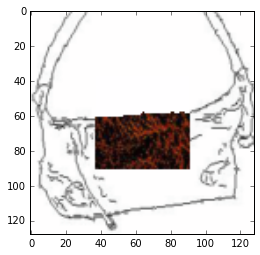

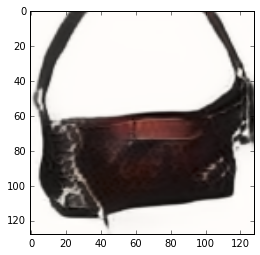

In [36]:
@interact(x=[0,25],xcenter=[0,128],ycenter=[0,128],size=[10,100])
def move_patch(x,xcenter,ycenter,size):
    img, skg, seg, eroded_seg, txt = data  # LAB with negeative value
    with torch.cuda.device(args.gpu):
        # this is in LAB value 0/100, -128/128 etc
        img = custom_transforms.normalize_lab(img)
        skg = custom_transforms.normalize_lab(skg)
        txt = custom_transforms.normalize_lab(txt)
        seg = custom_transforms.normalize_seg(seg)
        eroded_seg = custom_transforms.normalize_seg(eroded_seg)
        
        bs, w, h = seg.size()

        seg = seg.view(bs, 1, w, h)
        seg = torch.cat((seg, seg, seg), 1)
        
        eroded_seg = eroded_seg.view(bs, 1, w, h)
        eroded_seg = torch.cat((eroded_seg, eroded_seg, eroded_seg), 1)

        temp = torch.ones(seg.size()) * (1 - seg).float()
        temp[:, 1, :, :] = 0  # torch.ones(seg[:,1,:,:].size())*(1-seg[:,1,:,:]).float()
        temp[:, 2, :, :] = 0  # torch.ones(seg[:,2,:,:].size())*(1-seg[:,2,:,:]).float()

        txt = txt.float() * seg.float() + temp
        # seg=custom_transforms.normalize_lab(seg)
        # norm to 0-1 minus mean
        if not args.use_segmentation_patch:
            seg.fill_(1)
            eroded_seg.fill_(1)
        if args.input_texture_patch == 'original_image':
            inp, texture_loc = gen_input_exact(img, skg, eroded_seg[:, 0, :, :] * 100,xcenter,ycenter,size)
        elif args.input_texture_patch == 'dtd_texture':
            inp, texture_loc = gen_input_exact(txt, skg, eroded_seg[:, 0, :, :] * 100,xcenter,ycenter,size)

        img = img.cuda()
        skg = skg.cuda()
        seg = seg.cuda()
        txt = txt.cuda()
        inp = inp.cuda()
        
        input_stack = torch.FloatTensor().cuda()
        input_stack.resize_as_(inp.float()).copy_(inp)
        #target_img.resize_as_(img.float()).copy_(img)
        #segment.resize_as_(seg.float()).copy_(seg)

        inputv = Variable(input_stack)
        #targetv = Variable(target_img)
        
        netG.cuda()
        outputG = netG(inputv)

    if args.color_space == 'lab':
        out_img = vis_image(custom_transforms.denormalize_lab(outputG.data.double().cpu()),
                            args.color_space)
        if args.input_texture_patch == 'original_image':
            inp_img = vis_patch(custom_transforms.denormalize_lab(img.cpu()),
                                custom_transforms.denormalize_lab(skg.cpu()),
                                texture_loc,
                                args.color_space)
        elif args.input_texture_patch == 'dtd_texture':
            inp_img = vis_patch(custom_transforms.denormalize_lab(txt.cpu()),
                                custom_transforms.denormalize_lab(skg.cpu()),
                                texture_loc,
                                args.color_space)
        tar_img = vis_image(custom_transforms.denormalize_lab(img.cpu()),
                            args.color_space)
    elif args.color_space == 'rgb':

        out_img = vis_image(custom_transforms.denormalize_rgb(outputG.data.double().cpu()),
                            args.color_space)
        inp_img = vis_patch(custom_transforms.denormalize_rgb(img.cpu()),
                            custom_transforms.denormalize_rgb(skg.cpu()),
                            texture_loc,
                            args.color_space)
        tar_img = vis_image(custom_transforms.denormalize_rgb(img.cpu()),
                            args.color_space)
        
    plt.figure(1)    
    plt.imshow(np.transpose(inp_img[x],(1, 2, 0)))
    
    plt.figure(2)                    
    plt.imshow(np.transpose(out_img[x],(1, 2, 0)))